<a href="https://colab.research.google.com/github/ss8319/Colab-Notebooks/blob/main/Shamus_nmtNerAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [ ]:
!pip install xlsxwriter

import os
from pathlib import Path
from io import BytesIO
import math

import pandas as pd

# NLP Analysis
import spacy
import spacy.cli

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
# For a Jupyter notebook, show the Pandas plots right in the notebook
%matplotlib inline
cmap = cm.get_cmap('jet')

# Hard-coding - bad - don't do this ...
# from nlp.common.environment import paratextPreprocessedDir
paratextPreprocessedDir = Path(r'/content/drive/Shared drives/Gutenberg/Paratext/Paratext.preprocessed')

     |████████████████████████████████| 143kB 2.8MB/s 


## Specify the Test List and Target Languages to analyze

In [ ]:
# Specify the test list and TL list here
tests = ["04.13.1", "04.13.2", "04.13.3", "04.13.4", "04.13.5" ]
tls = ["en", "es", "fr" ]

# NER Analysis

## Reference: NER Tags
Tags are accessible through the `.label_` property of an entity.
<table>
<tr><th>TYPE</th><th>DESCRIPTION</th><th>EXAMPLE</th></tr>
<tr><td>`PERSON`</td><td>People, including fictional.</td><td>*Fred Flintstone*</td></tr>
<tr><td>`NORP`</td><td>Nationalities or religious or political groups.</td><td>*The Republican Party*</td></tr>
<tr><td>`FAC`</td><td>Buildings, airports, highways, bridges, etc.</td><td>*Logan International Airport, The Golden Gate*</td></tr>
<tr><td>`ORG`</td><td>Companies, agencies, institutions, etc.</td><td>*Microsoft, FBI, MIT*</td></tr>
<tr><td>`GPE`</td><td>Countries, cities, states.</td><td>*France, UAR, Chicago, Idaho*</td></tr>
<tr><td>`LOC`</td><td>Non-GPE locations, mountain ranges, bodies of water.</td><td>*Europe, Nile River, Midwest*</td></tr>
<tr><td>`PRODUCT`</td><td>Objects, vehicles, foods, etc. (Not services.)</td><td>*Formula 1*</td></tr>
<tr><td>`EVENT`</td><td>Named hurricanes, battles, wars, sports events, etc.</td><td>*Olympic Games*</td></tr>
<tr><td>`WORK_OF_ART`</td><td>Titles of books, songs, etc.</td><td>*The Mona Lisa*</td></tr>
<tr><td>`LAW`</td><td>Named documents made into laws.</td><td>*Roe v. Wade*</td></tr>
<tr><td>`LANGUAGE`</td><td>Any named language.</td><td>*English*</td></tr>
<tr><td>`DATE`</td><td>Absolute or relative dates or periods.</td><td>*20 July 1969*</td></tr>
<tr><td>`TIME`</td><td>Times smaller than a day.</td><td>*Four hours*</td></tr>
<tr><td>`PERCENT`</td><td>Percentage, including "%".</td><td>*Eighty percent*</td></tr>
<tr><td>`MONEY`</td><td>Monetary values, including unit.</td><td>*Twenty Cents*</td></tr>
<tr><td>`QUANTITY`</td><td>Measurements, as of weight or distance.</td><td>*Several kilometers, 55kg*</td></tr>
<tr><td>`ORDINAL`</td><td>"first", "second", etc.</td><td>*9th, Ninth*</td></tr>
<tr><td>`CARDINAL`</td><td>Numerals that do not fall under another type.</td><td>*2, Two, Fifty-two*</td></tr>
</table>

## NER Subroutines

In [ ]:
# Count the NER occurrences in a set of verses
def getPdNerList(nlp,thisFile):
    with open(thisFile,'r',encoding='utf-8') as f:
        doc = nlp(f.read())
    with open('./ent.csv','w',encoding='utf-8') as f:
        for ent in doc.ents:
            f.write(f'{ent.label_}____{ent.text.lower()}\n')
    dfObj = pd.read_csv("./ent.csv", sep='____',engine='python')
    dfObj.columns=["NER","TOKEN"]

    return dfObj


enNlp = None
esNlp = None
frNlp = None

# Select the spacy NLP model that should be used for a given language.
# Download and load it if it's not already available.
def getNlpByLang(lang):
    global enNlp
    global esNlp
    global frNlp

    if lang == 'en':
        if enNlp == None:
            enNlp = spacy.load('en_core_web_sm')  # Also _md and _lg
        return enNlp
    elif lang == 'fr':
        if frNlp == None:
            # This model is not automatically available on Colab; download it
            spacy.cli.download('fr_core_news_sm')
            frNlp = spacy.load('fr_core_news_sm') # Also _md
        return frNlp
    elif lang == 'es':
        if esNlp == None:
            # This model is not automatically available on Colab; download it
            spacy.cli.download('es_core_news_sm')
            esNlp = spacy.load('es_core_news_sm') # Also _md
        return esNlp
    return None


# Load the actual verses and predicted verses for the specified language, and
# return a NER type data frame for each (actual, predicted)
def getPdNerData(lang):
    # Make sure it's a supported langauge
    if lang not in [ "en", "es", "fr"]:
        return None
    nlp = getNlpByLang(lang)

    # Load the actual and predicted verses
    actualFile=f'{lang}-actuals.txt'
    predictFile=f'{lang}-predictions.txt'

    # Convert the verses to NER lists
    aNerDf = getPdNerList(nlp,actualFile)
    pNerDf = getPdNerList(nlp,predictFile)

    return aNerDf, pNerDf


# Create a DF that contains the actual/predicted counts, difference, and diff.
# %age for each NER type
def calcNerDeltas(aNerDf,pNerDf):
    # Count the NER instances of each NER type in the actual text
    aCounts = aNerDf.groupby(["NER"]).count()
    aCounts.columns = ["ACOUNTS"]
    # Count the NER instances of each NER type in the predicted text
    pCounts = pNerDf.groupby(["NER"]).count()
    pCounts.columns = ["PCOUNTS"]
    # Join the data from the actuals and predictions data frames
    diffCounts = pd.concat([aCounts,pCounts], axis=1)
    # Add columns showing the actual vs prediction delta counts and %'age
    diffCounts["DELTAS"] = diffCounts["PCOUNTS"] - diffCounts["ACOUNTS"]
    diffCounts["DELTAPCT"] = 100*(diffCounts["PCOUNTS"] - diffCounts["ACOUNTS"]) / diffCounts["ACOUNTS"]

    return diffCounts


# Show a table of the NER differences
def showNerDeltas(diffCounts):
    print(f'{diffCounts.sort_values(["DELTAPCT","DELTAS"], ascending=(False,False))}')


def saveImageToWorksheet(worksheet,fig,rowOffset,colOffset):
    # Generate an image from the Pandas plot(s)
    imgdata = BytesIO()
    fig.savefig(imgdata, format="jpeg")
    imgdata.seek(0)
    # Save the image to a sheet in the workbook.  Shift it 20 columns to the left
    # so that there is room for the summary chart.
    worksheet.insert_image(rowOffset, colOffset, "", {'image_data': imgdata})



## Plot Actual vs Predicted NER Counts by Test, Target Language and NER

In addition to the plot below this cell, this code will produce an Excel spreadsheet with the actual and predicted NER counts for the specified list of TEST + TL combinations.  The spreadsheet will have a separate worksheet for each TEST+TL combination.  The spreadsheet will be called 'ner.xlsx', and it will be created in the first test folder specified in the 'tests' list.

Test: 04.13.1 Language: en; NER Actuals: 336; NER Predictions: 228
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
Test: 04.13.1 Language: es; NER Actuals: 574; NER Predictions: 158
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
Test: 04.13.1 Language: fr; NER Actuals: 436; NER Predictions: 244
Test: 04.13.2 Language: en; NER Actuals: 616; NER Predictions: 421
Test: 04.13.2 Language: es; NER Actuals: 1127; NER Predictions: 271
Test: 04.13.2 Language: fr; NER Actuals: 839; NER Predictions: 307
Test: 04.13.3 Language: en; NER Actuals: 352; NER Predictions: 226
Test: 04.13.3 Language: es; NER Actuals: 586; NER Predictions: 179
Test: 04.13.3 Language: fr; NER Actuals: 456; NER Predictions: 311
Test: 04.13.4 Language: en; NER Actuals: 350; NER Predictions: 242
Test: 04.13.4 Language: es; NER Actuals: 612; NER Predictions: 129
Test: 04.13.4 Language: fr; NER Actuals: 417; NER Predictions:

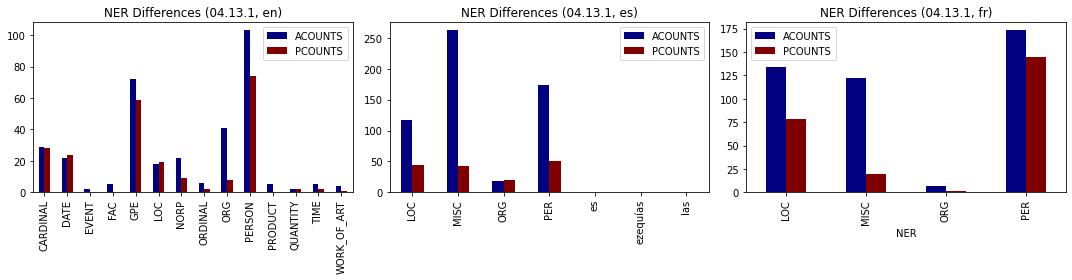

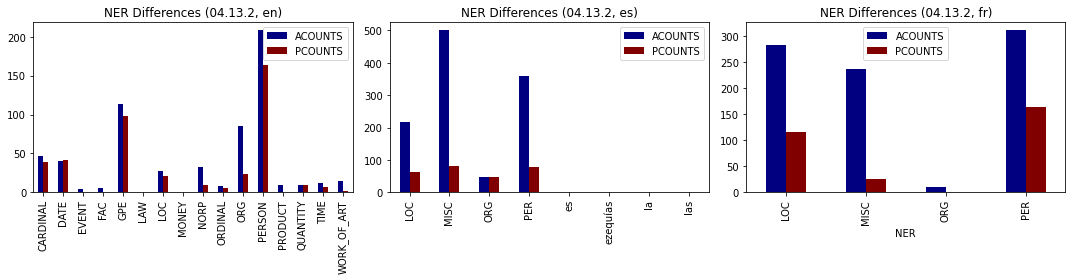

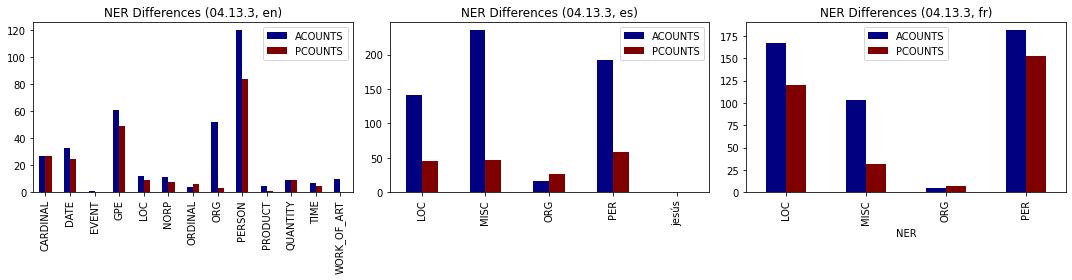

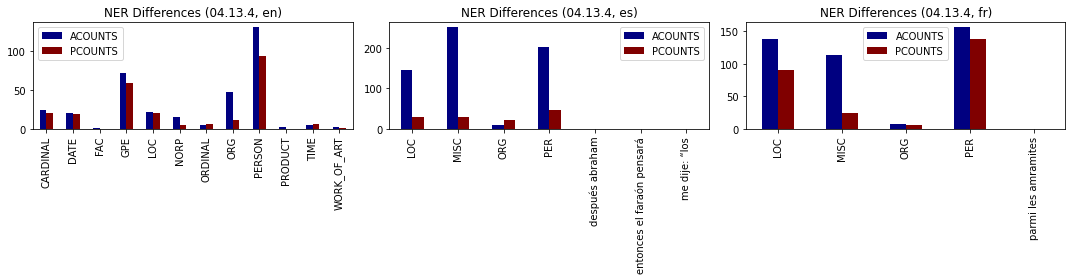

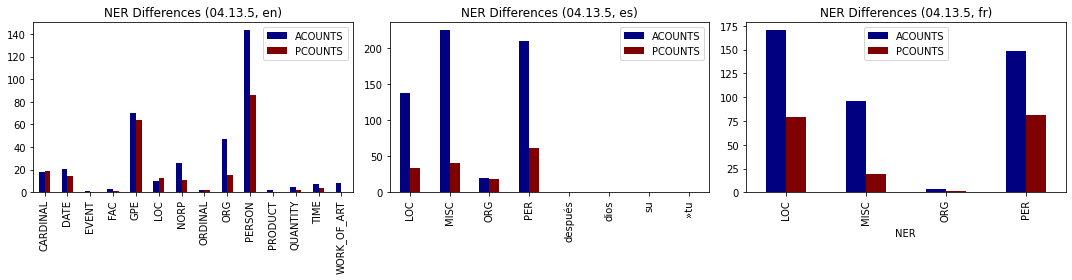

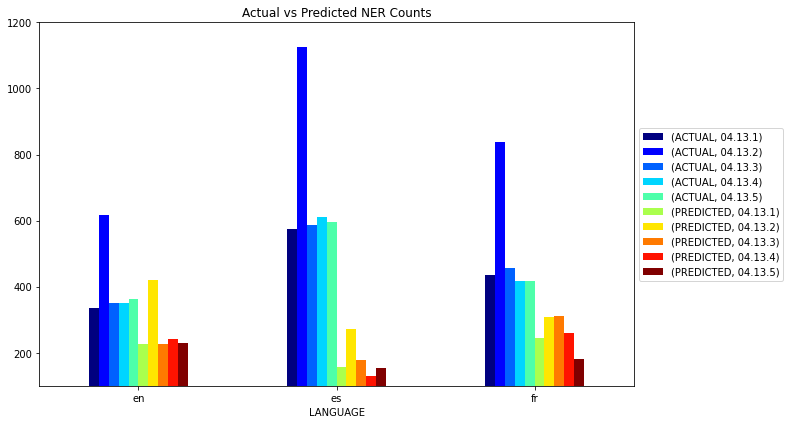

In [ ]:
# Plot the NER differences across a range of tests and target languages

# Set up a writer for the Excel output
writer = pd.ExcelWriter(r'./ner.xlsx')
workbook = writer.book
worksheet = workbook.add_worksheet('NER Charts')

# Set up an empty DF to store the overall NER counts
nerCounts = pd.DataFrame(columns=["TEST", "LANGUAGE", "ACTUAL", "PREDICTED"])

testNum = 0
for test in tests:
    # Set up the necessary number of subplots for this cell
    figWidth = min(5*len(tls),20)
    fig, axs = plt.subplots(1,len(tls),figsize=(figWidth,4))

    tlNum = 0
    for tl in tls:
        # Navigate to the test results folder
        os.chdir(os.path.join(paratextPreprocessedDir, "tests", f"1-to-n-2020.{test}"))
        # Generate the NER counts for the target language
        (aNerDf,pNerDf) = getPdNerData(tl)

        # Print and save the overall NER count results
        print (f"Test: {test} Language: {tl}; NER Actuals: {len(aNerDf.index)}; NER Predictions: {len(pNerDf.index)}")
        nerCounts = nerCounts.append({"TEST": test, "LANGUAGE": tl, "ACTUAL": len(aNerDf.index), "PREDICTED": len(pNerDf.index)}, ignore_index=True)
        # Calculate the deltas for each individual NER and plot them
        diffCounts = calcNerDeltas(aNerDf,pNerDf)

        # Augment and restructure the actual/predicted POS data
        aNerDf['SOURCE'] = "Actual"
        pNerDf['SOURCE'] = 'Predicted'
        nerDf = pd.concat([aNerDf, pNerDf], axis = 0)
        nerPivot = pd.pivot_table(nerDf,index=['NER','TOKEN'],columns=['SOURCE'],aggfunc='size')

        # Save the data to the Excel file
        sheetName = f'NER.{test}.{tl}'
        nerDf.to_excel(writer,sheet_name=sheetName,index=False,
                        columns=['SOURCE','NER','TOKEN'],
                        startrow=0,startcol=0)
        nerPivot.to_excel(writer,sheet_name=sheetName,
                          float_format="%.0f", na_rep="", startrow=0,startcol=6)

        # Plot the results
        if len(tls) == 1:
            diffCounts[["ACOUNTS","PCOUNTS"]].plot(kind="bar", cmap=cmap, ax=axs)
        else:
            diffCounts[["ACOUNTS","PCOUNTS"]].plot(kind="bar", cmap=cmap, ax=axs[tlNum])
        axs[tlNum].set_title(f'NER Differences ({test}, {tl})')

        tlNum = tlNum + 1

    fig.tight_layout()
    saveImageToWorksheet(worksheet,fig,30+testNum*22,0)

    testNum = testNum + 1


# Create another plot for the summary chart
fig, axs = plt.subplots(1,1,figsize=(12,6))
# Plot the overall POS counts (actual vs predicted) collected by the previous cell
nerCounts.pivot(index='LANGUAGE',
                columns='TEST',
                values=['ACTUAL','PREDICTED']).plot(kind="bar", title="Actual vs Predicted NER Counts",
                                                    cmap=cmap, rot=0, ax = axs)

ylimLower = min(nerCounts['ACTUAL'].min(),nerCounts['PREDICTED'].min())
ylimUpper = max(nerCounts['ACTUAL'].max(),nerCounts['PREDICTED'].max())
ylimLower = int(math.floor(ylimLower/100)) * 100
ylimUpper = int(math.ceil(ylimUpper/100)) * 100
axs.set_ylim(ylimLower,ylimUpper)

fig.tight_layout(rect=[0,0,0.75,1])
axs.legend(loc='center left', bbox_to_anchor=(1,0.5))
saveImageToWorksheet(worksheet,fig,0,0)

# Complete the Excel output
os.chdir(os.path.join(paratextPreprocessedDir, "tests", f"1-to-n-2020.{tests[0]}"))
writer.save()